In [2]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences
from keras.layers import GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
SEED = 42

dataset = pd.read_csv('WELFake_Dataset.csv').dropna()
labels, dataset = (dataset['label'], dataset.drop(columns=['Unnamed: 0']))


dataset

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [5]:
sum(dataset['label'])

36509

In [6]:
dataset['text'] = dataset['title'] + ' '+ dataset['text']

data = dataset['text']
labels = dataset['label']


In [7]:
data

0        LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2        UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3        Bobby Jindal, raised Hindu, uses story of Chri...
4        SATAN 2: Russia unvelis an image of its terrif...
5        About Time! Christian Group Sues Amazon and SP...
                               ...                        
72129    Russians steal research on Trump in hack of U....
72130     WATCH: Giuliani Demands That Democrats Apolog...
72131    Migrants Refuse To Leave Train At Refugee Camp...
72132    Trump tussle gives unpopular Mexican leader mu...
72133    Goldman Sachs Endorses Hillary Clinton For Pre...
Name: text, Length: 71537, dtype: object

In [56]:
dataset['word_count'] = dataset['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribuição de Quantidade de Palavras')

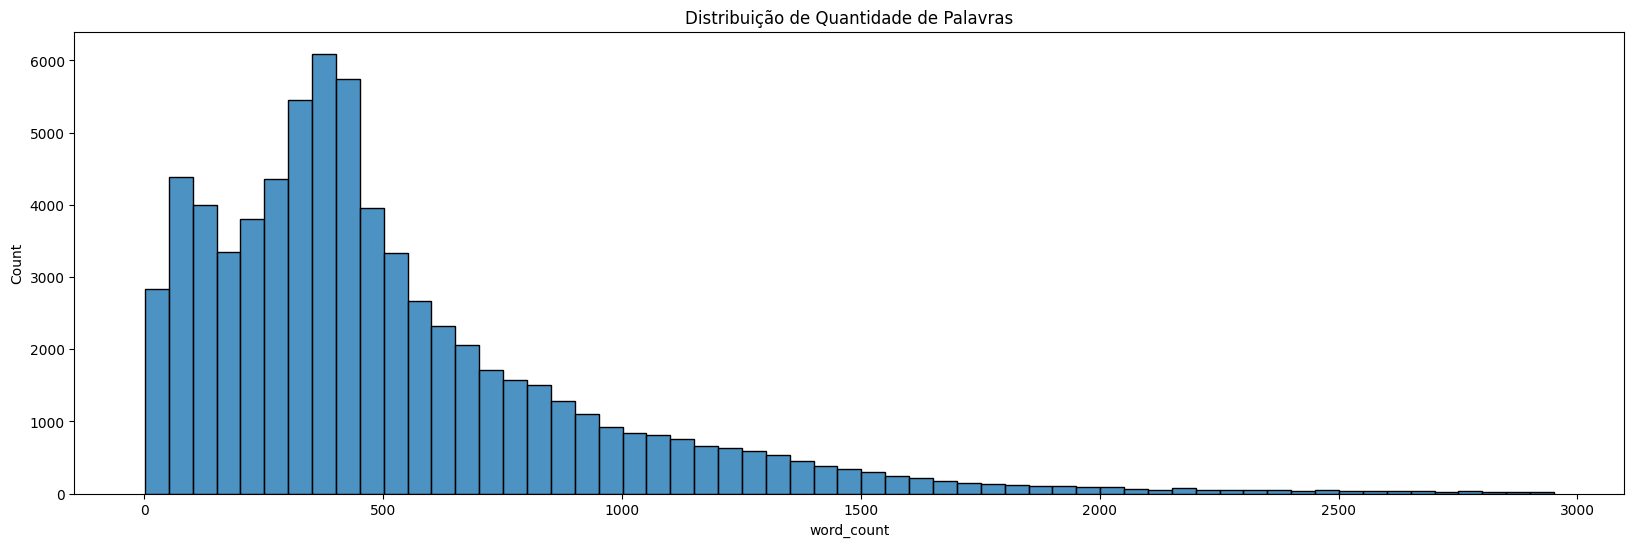

In [59]:
plt.figure(figsize = (20,6))
sns.histplot(dataset['word_count'], bins = range(1, 3000, 50), alpha = 0.8)
plt.title('Distribuição de Quantidade de Palavras')

In [ ]:
plt.figure(figsize = (8,5))
sns.countplot(x = dataset['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribuição de labels')

# Separando treino e teste

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify = labels, random_state = SEED)

# Tokenização

In [11]:
tok = Tokenizer()
tok.fit_on_texts(X_train)

train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)


print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 286000


In [38]:
train_sequences[0][1]

1

# Padding sequencias

In [8]:
MAX_LEN = 600

In [13]:


train_sequences_pad = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_pad = pad_sequences(test_sequences, maxlen=MAX_LEN)

In [14]:
train_sequences_pad.shape

(53652, 600)

In [37]:
test_sequences_pad.shape

(17885, 600)

In [46]:
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index) + 1, 128),
    Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(50)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 600, 128)          36608128  
                                                                 
 bidirectional_8 (Bidirectio  (None, 600, 200)         183200    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [40]:
tf.keras.utils.plot_model(model, to_file='graph.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]

history = model.fit(train_sequences_pad,
                    y_train,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=callbacks)

Epoch 1/10
 63/671 [=>............................] - ETA: 3:33:52 - loss: 0.6904 - accuracy: 0.5603

KeyboardInterrupt: 

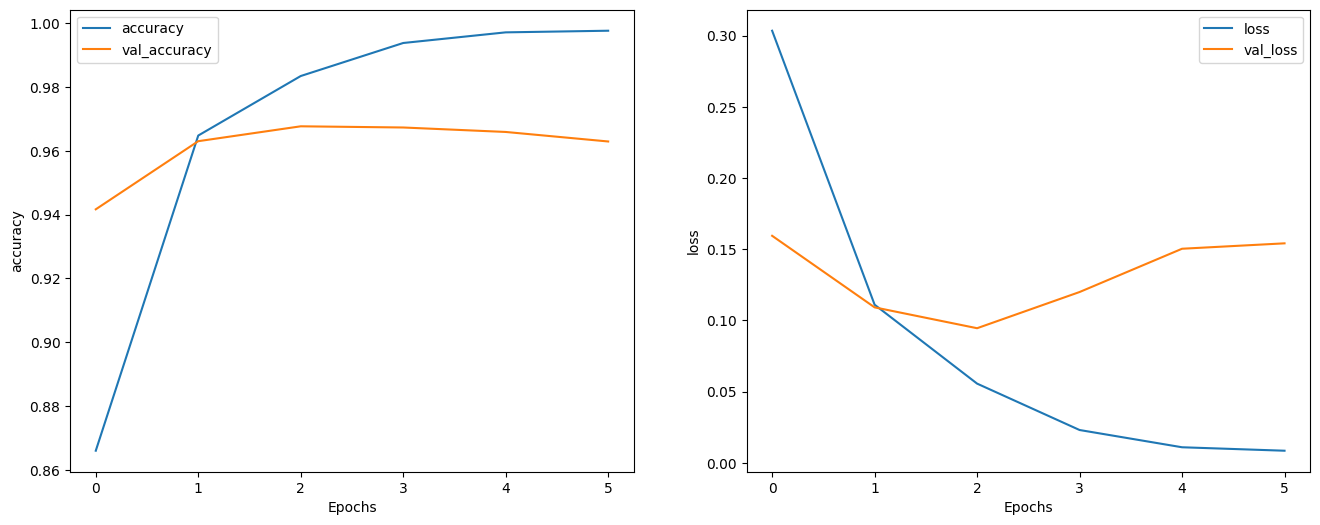

In [19]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):
    
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [20]:
test_loss, test_acc = model.evaluate(test_sequences_pad, y_test)
y_hat = model.predict(test_sequences_pad)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

559/559 [==============================] - 199s 354ms/step
Test Loss: 0.09965704381465912
Test Accuracy: 0.9663964509963989


Text(70.72222222222221, 0.5, 'Classes reais')

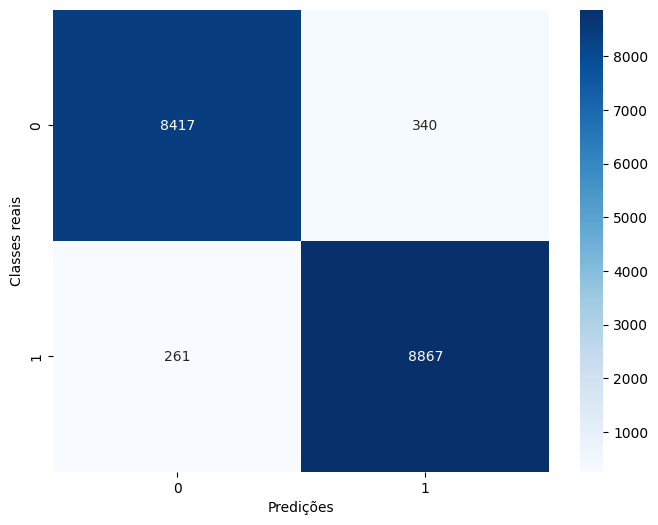

In [26]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predições')
plt.ylabel('Classes reais')